## 精準行銷 - 透過共現圖分析電訪對話資料

In [1]:
import pandas as pd
import numpy as np
import jieba.analyse

In [2]:
stopWords = []
with open('data/stopWords.txt', 'r', encoding='UTF-8') as file:
    for data in file.readlines():
        data = data.strip()
        stopWords.append(data)

In [3]:
stoplst = [' ', '\xa0']
for words in stoplst:
    stopWords.append(words)

In [4]:
with open('data/ner.txt', 'r', encoding='UTF-8') as file:
    for data in file.readlines():
        data = data.strip()
        jieba.add_word(data)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\pecu6\AppData\Local\Temp\jieba.cache
Loading model cost 0.817 seconds.
Prefix dict has been built successfully.


In [5]:
df_terms = pd.read_csv('data/customer.csv')

In [6]:
df_terms.head()

Unnamed: 0        類別 Unique ID             資料日期  \
0           0  Call Out    AA2765  20180102 141000   
1           1  Call Out    AA3910  20180102 144300   
2           2  Call Out    AA3167  20180102 154500   
3           3  Call Out    AA2355  20180102 194359   
4           4  Call Out    AA2778  20180103 111132   

                            客戶事件描述  
0  [ECP] 去電確認開戶文件 客戶說後來去買美元保單就不開戶了  
1               [ECP]不方說  IPO MAIL  
2                [ECP] IPO 忙 先MAIL  
3           家庭戶 媽媽說女兒不開了，因為打工收入不穩定  
4                              推Q1

In [9]:
error_lst = []
terms=[]
for i in range(len(df_terms['客戶事件描述'])):
    try:
        for j in list(jieba.cut(df_terms['客戶事件描述'][i], cut_all = False)):
            if j not in stopWords:
                terms.append(j)
    except:
        error_lst.append([i, df_terms['客戶事件描述'][i]])

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import jieba
import codecs
import jieba.posseg as pseg

In [11]:
names = {}          
relationships = {}  
lineNames = []  
for i in range(len(df_terms['客戶事件描述'])):
    try:
        poss = jieba.cut(df_terms['客戶事件描述'][i], cut_all = False)
        lineNames.append([])
        for w in poss:
            if w not in stopWords:
                lineNames[-1].append(w)        
            if names.get(w) is None and w not in stopWords:    
                relationships[w] = {}            
    except:
        pass

In [12]:
term_dic = dict()
for sentence in lineNames:
    for term in sentence:
        if term not in term_dic:
            term_dic[term] = {}

In [ ]:
for i in range(len(lineNames)):
    for term1 in term_dic:
        num = 0
        for term2 in lineNames[i]:
            if term1 == term2:
                num += 1
        term_dic[term1][df_terms['客戶事件描述'][i]] = num

In [ ]:
TDM = pd.DataFrame.from_dict(term_dic)
TDM.head()

## Cooccurrence Matrix

In [92]:
names = {}          
relationships = {}  
lineNames = []     

for i in range(len(df_terms['客戶事件描述'])):
    try:
        poss = jieba.cut(df_terms['客戶事件描述'][i], cut_all = False)
        lineNames.append([])
        for w in poss:
            if w not in stopWords:
                lineNames[-1].append(w)        
            if names.get(w) is None and w not in stopWords:
                names[w] = 0
                relationships[w] = {}
                names[w] += 1   
    except:
        pass

for line in lineNames:                  
    for name1 in line:                  
        for name2 in line:             
            if name1 == name2:
                continue
            if relationships[name1].get(name2) is None:     
                relationships[name1][name2]= 1
            else:
                relationships[name1][name2] = relationships[name1][name2]+ 1       
co_occur_by_records = [[name, v, w] for name, edges in relationships.items() for v, w in edges.items() if w > 25]

In [93]:
np.random.shuffle(co_occur_by_records)
temp_matrix = pd.DataFrame()
for i in co_occur_by_records:
    temp_matrix.at[i[0], i[1]] = i[2]
co_occurrence_matrix_by_records = pd.DataFrame()
for i in temp_matrix:
    for j in temp_matrix:
        co_occurrence_matrix_by_records.at[i, j] = temp_matrix.at[i, j]
co_occurrence_matrix_by_records.head()

報訂     蹤    ec   寄     P    看看    寄回    退休     EC   幣  ...   買    電子  \
報訂 NaN   NaN   NaN NaN   NaN   NaN   NaN  73.0    NaN NaN  ... NaN  78.0   
蹤  NaN   NaN  29.0 NaN  59.0   NaN   NaN   NaN   99.0 NaN  ... NaN   NaN   
ec NaN  29.0   NaN NaN   NaN   NaN   NaN   NaN    NaN NaN  ... NaN   NaN   
寄  NaN   NaN   NaN NaN   NaN   NaN   NaN   NaN    NaN NaN  ... NaN   NaN   
P  NaN  59.0   NaN NaN   NaN  27.0  32.0   NaN  482.0 NaN  ... NaN   NaN   

      專刊  Q1    手機  分配  名單     推  人民  文件  
報訂  78.0 NaN   NaN NaN NaN   NaN NaN NaN  
蹤    NaN NaN   NaN NaN NaN   NaN NaN NaN  
ec   NaN NaN   NaN NaN NaN   NaN NaN NaN  
寄   26.0 NaN   NaN NaN NaN   NaN NaN NaN  
P    NaN NaN  29.0 NaN NaN  41.0 NaN NaN  

[5 rows x 27 columns]

In [94]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))
count_by_records = [i[2] for i in co_occur_by_records]
co_occur_by_records_sig = []
for i in co_occur_by_records:
    co_occur_by_records_sig.append([i[0], i[1], sigmoid((i[2] - np.mean(count_by_records))/np.std(count_by_records))])

In [95]:
import matplotlib
print(matplotlib.__file__)

c:\python37\lib\site-packages\matplotlib\__init__.py


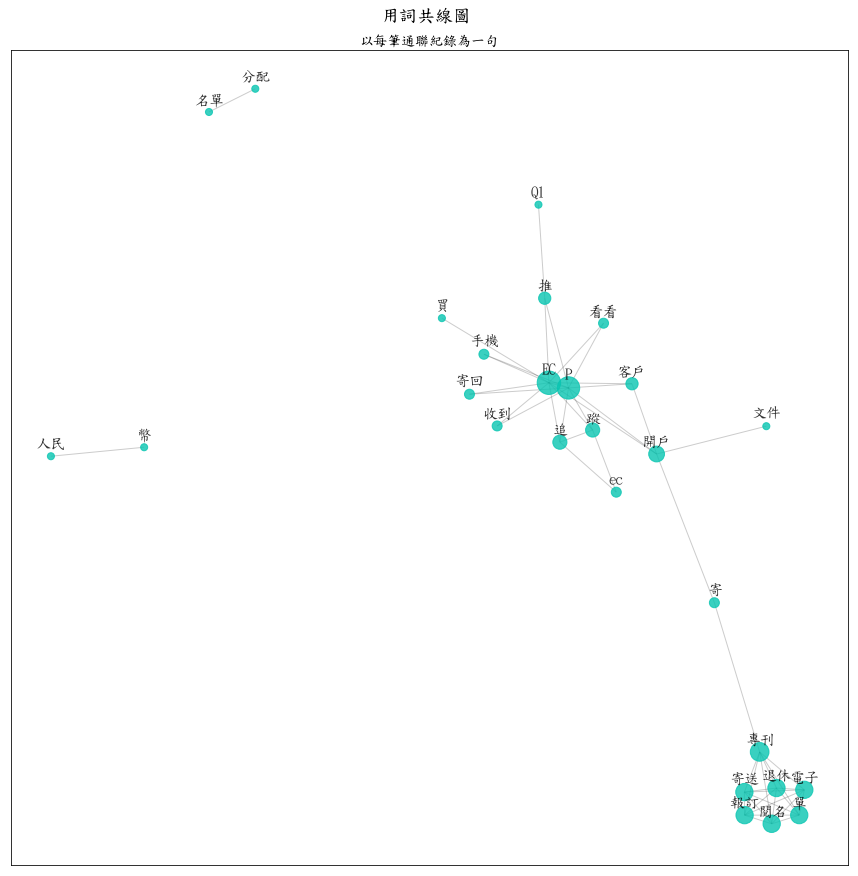

In [96]:
plt.figure(figsize=(15,15))
plt.rcParams['font.sans-serif'] = ['DFKai-SB']   
g = nx.Graph()
g.add_weighted_edges_from(co_occur_by_records_sig)
pos=nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, alpha=0.8,node_size=[val*50 for (node, val) in g.degree()], node_color='#08c5b1')
nx.draw_networkx_edges(g, pos, node_color='b', alpha=0.2)
for p in pos:  # raise text positions
    pos[p][1] = pos[p][1] + 0.03
nx.draw_networkx_labels(g, pos, font_size = 15, font_family='sans-serif', alpha=0.8)
plt.title('以每筆通聯紀錄為一句', size = 14)
plt.suptitle('用詞共線圖',x = 0.51,y=0.92, fontsize=18)
plt.show()

## 以每個客戶為基準，再做一次

In [97]:
df_event = pd.DataFrame()
for i in df_terms['Unique ID'].value_counts().index:
    for j in df_terms[df_terms['Unique ID'] == i].reset_index().index :
        df_event.at[i, j] = df_terms[df_terms['Unique ID'] == i].reset_index().at[j, '客戶事件描述']
df_by_id = pd.DataFrame()
df_by_id['客戶事件描述'] = df_event[0]
df_by_id.index = df_event.index
for i in df_event.index:
    df_by_id.at[i, '客戶事件描述']  = ' '.join([str(j) for j in df_event.loc[i] if not pd.isna(j)])

In [98]:
df_by_id.head()

客戶事件描述
AA4372  網路上看ipo  美及人有機會  線上填 先作這一支境內/境外之后再補  有告知經理費1.5...
AA2986  現場客戶，318359 羅金雄的朋友MGM，3/1再打過去問地址, 台外幣都用款項，國泰/中...
AA1538  開戶追蹤 再重寄表格  轉介208 台北富邦或合庫 208 娘298803廖○霞 去電娘29...
AA6076  [ECP]境外ES被退:無此使用者,客戶的兒子說少打tw,寄表單修改 [ECP]想要買回，要...
AA3336  Money 電子報訂閱名單,寄送退休專刊,看表單再決定銀行 [ECP]follow 名單,有...

In [99]:
names = {}          
relationships = {}  
lineNames = []     

for i in range(len(df_by_id['客戶事件描述'])):
    try:
        poss = jieba.cut(df_by_id['客戶事件描述'][i], cut_all = False)
        lineNames.append([])
        for w in poss:
            if w not in stopWords:
                lineNames[-1].append(w)        
            if names.get(w) is None:
                names[w] = 0
            relationships[w] = {}
            names[w] += 1   
    except:
        pass

for line in lineNames:                  
    for name1 in line:                  
        for name2 in line:             
            if name1 == name2:
                continue
            if relationships[name1].get(name2) is None:     
                relationships[name1][name2]= 1
            else:
                relationships[name1][name2] = relationships[name1][name2]+ 1       
co_occur_by_unicodes = [[name, v, w] for name, edges in relationships.items() for v, w in edges.items() if w > 50]

In [100]:
np.random.shuffle(co_occur_by_unicodes)
temp_matrix = pd.DataFrame()
for i in co_occur_by_unicodes:
    temp_matrix.at[i[0], i[1]] = i[2]
co_occurrence_matrix_by_unicodes = pd.DataFrame()
for i in temp_matrix:
    for j in temp_matrix:
        co_occurrence_matrix_by_unicodes.at[i, j] = temp_matrix.at[i, j]

In [101]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))
count_by_unicodes = [i[2] for i in co_occur_by_unicodes]
co_occur_by_unicodes_sig = []
for i in co_occur_by_unicodes:
    co_occur_by_unicodes_sig.append([i[0], i[1], sigmoid((i[2] - np.mean(count_by_unicodes))/np.std(count_by_unicodes))])

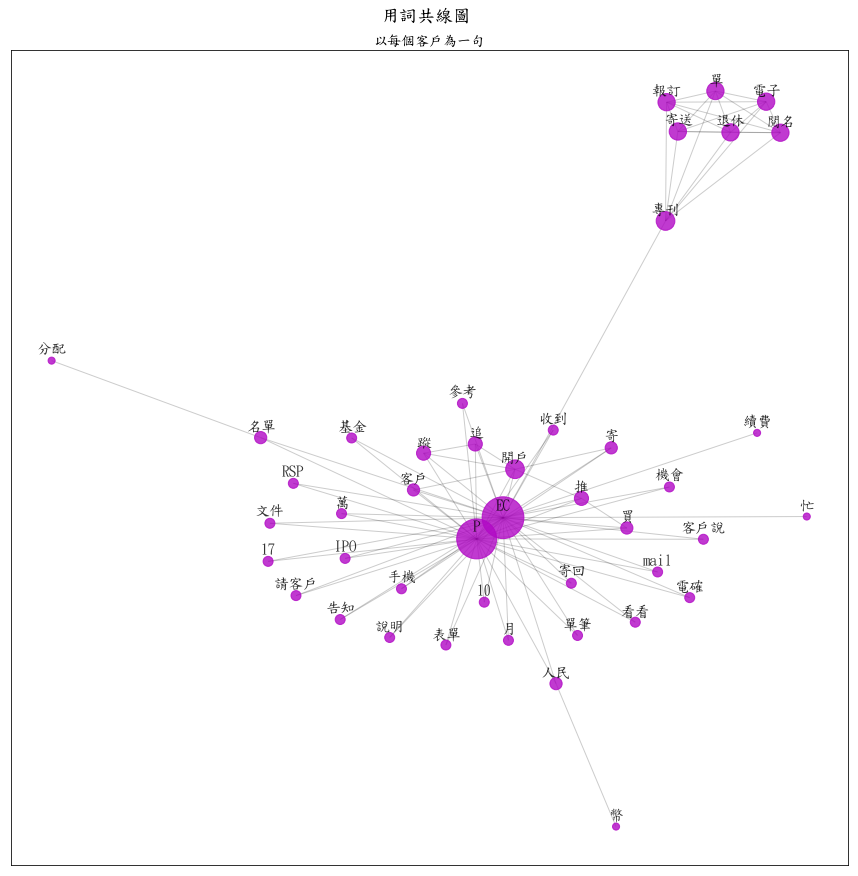

In [102]:
plt.figure(figsize=(15,15))
g = nx.Graph()
g.add_weighted_edges_from(co_occur_by_unicodes_sig)
pos=nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, alpha=0.8, node_size=[val*50 for (node, val) in g.degree()], node_color='#b108c5')
nx.draw_networkx_edges(g, pos, node_color='b', alpha=0.2) 
for p in pos:  # raise text positions
    pos[p][1] = pos[p][1] + 0.03
nx.draw_networkx_labels(g, pos, font_size = 15, font_family='sans-serif', alpha=0.8)
plt.title('以每個客戶為一句', size = 14)
plt.suptitle('用詞共線圖',x = 0.51,y=0.92, fontsize=18)
#plt.savefig("image/用詞共線圖_以每個客戶為一句.png", dpi=100)
plt.show()